In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import quandl

In [3]:
apikey= ''

In [4]:
# Get stock data from the Quandl API

stock_price = quandl.get('EOD/CVX', start_date='2013-01-01', end_date='2018-12-31',
                    authtoken=apikey)

In [5]:
stock_price_df = stock_price[['Adj_Close']]
stock_price_df.head(2)

,Adj_Close
Date,
2013-09-03,95.060311
2013-09-04,95.304763


In [6]:
# Read inflation rate data into a pandas dataframe, convert DATE column to a Datetime format, amd make it the index column

infl_rate_df = pd.read_csv('data/5year_breakeven_inflation _rate.csv', parse_dates=['DATE'], index_col=0)

In [7]:
infl_rate_df.head(2)

,T5YIE
DATE,
2013-01-02,2.12
2013-01-03,2.11


## Data Wrangling

In [8]:
infl_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2013-01-02 to 2017-12-29
Data columns (total 1 columns):
T5YIE    1303 non-null object
dtypes: object(1)
memory usage: 20.4+ KB


Inflation Rate needs to be converted to numeric

In [9]:
# Rename the columns

infl_rate_df = infl_rate_df.rename(columns={'DATE': 'Date', 'T5YIE': 'Infl_Rate'})
infl_rate_df.head()

,Infl_Rate
DATE,
2013-01-02,2.12
2013-01-03,2.11
2013-01-04,2.13
2013-01-07,2.16
2013-01-08,2.15


In [10]:
# Convert Infl_Rate column to numeric

infl_rate_df.Infl_Rate = pd.to_numeric(infl_rate_df.Infl_Rate, errors='coerce')

In [11]:
# Check for NaN values

infl_rate_df.isnull().sum()

Infl_Rate    52
dtype: int64

In [12]:
# Fill NaN values with the mean of the prev and next values

infl_rate_df.Infl_Rate = infl_rate_df.Infl_Rate.interpolate()

In [13]:
# Merge both dataframes

stock_df = pd.merge(stock_price_df, infl_rate_df, left_index=True, right_index=True)

In [14]:
stock_df.head()

,Adj_Close,Infl_Rate
2013-09-03,95.060311,1.76
2013-09-04,95.304763,1.74
2013-09-05,95.706926,1.71
2013-09-06,95.580758,1.71
2013-09-09,96.377198,1.69


In [15]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1090 entries, 2013-09-03 to 2017-12-28
Data columns (total 2 columns):
Adj_Close    1090 non-null float64
Infl_Rate    1090 non-null float64
dtypes: float64(2)
memory usage: 25.5 KB


In [16]:
stock_df.describe()

,Adj_Close,Infl_Rate
count,1090.000000,1090.000000
mean,92.453742,1.582165
std,10.587766,0.241333
min,59.554419,0.930000
25%,87.800495,1.390000
50%,93.810748,1.630000
75%,99.465604,1.760000
max,117.748821,2.050000


## Data preprocessing

In [17]:
# Since the stock data is on a 'Business Day', there is a gap in the Time Series. Fill the Time Series gap by converting it to a
# Daily frequency, and the values with a Forward Fill. 

stock_df = stock_df.asfreq(freq='D', method='ffill') 
stock_df.head(10)

,Adj_Close,Infl_Rate
2013-09-03,95.060311,1.76
2013-09-04,95.304763,1.74
2013-09-05,95.706926,1.71
2013-09-06,95.580758,1.71
2013-09-07,95.580758,1.71
2013-09-08,95.580758,1.71
2013-09-09,96.377198,1.69
2013-09-10,97.000157,1.74
2013-09-11,97.717742,1.76
2013-09-12,97.694085,1.75


In [18]:
# Examine the eigen values to check for stationarity
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html
#coint_johansen(data, no deterministic term(-1), num of lagged differences)

coint_johansen(stock_df,-1,0).eig

array([0.01122146, 0.00033953])

In [19]:
# Make the Time Series stationary

data = np.log(stock_df).diff().dropna()

coint_johansen(data,-1,1).eig

array([0.36542129, 0.32721761])

## Vector Auto Regression

In [20]:
# Split dataset into train and test 

y_train = data[:int(0.8*(len(data)))]
y_test = data[int(0.8*(len(data))):]

In [21]:
# Instantiate the model
 
model = VAR(y_train.values) 

In [22]:
model_fit = model.fit(maxlags=5, ic='aic')

In [23]:
#model_fit.summary()

#model_fit.plot_acorr()

In [24]:
forecast = model_fit.forecast(y_test.values, steps=len(y_test))  

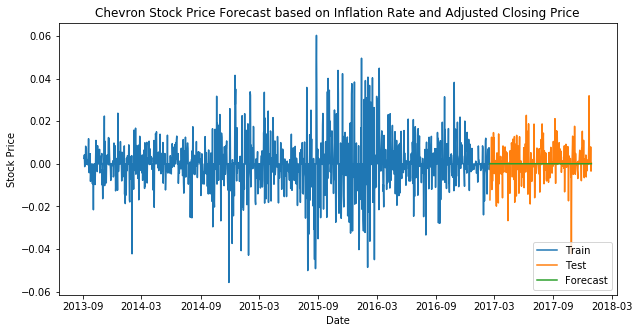

In [25]:
# plot the predictions for test set

plt.figure(figsize= (10,5))
plt.plot(y_train.Adj_Close, label='Train')
plt.plot(y_test.Adj_Close, label='Test')
plt.plot(y_test.index, forecast[:,:1], label='Forecast')
plt.legend(loc='lower right')
plt.title('Chevron Stock Price Forecast based on Inflation Rate and Adjusted Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

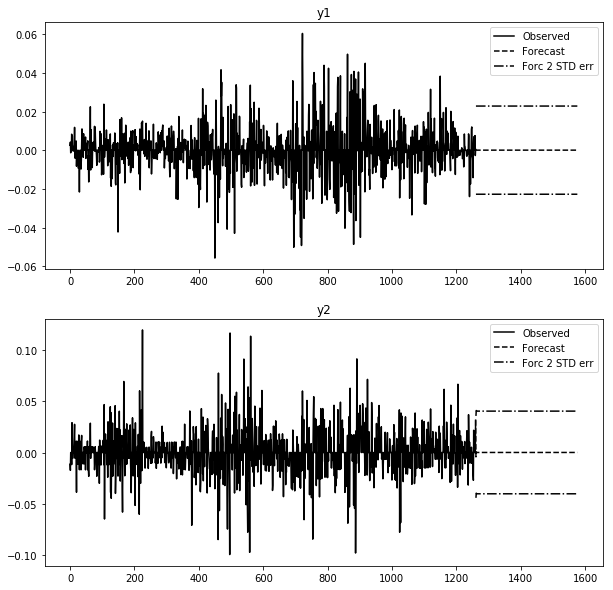

In [26]:
model_fit.plot_forecast(len(y_test), plot_stderr=True)


In [27]:
rmse = sqrt(mean_squared_error(y_test,forecast))
print('RMSE:', round(rmse,4))

RMSE: 0.0127


In [28]:
# Reverse the diff to make the series non-stationary

In [29]:
y_train_cumsum = y_train.Adj_Close.cumsum()
y_test_cumsum = y_test.Adj_Close.cumsum()

In [30]:
forecast_cumsum = forecast[:,:1].cumsum()

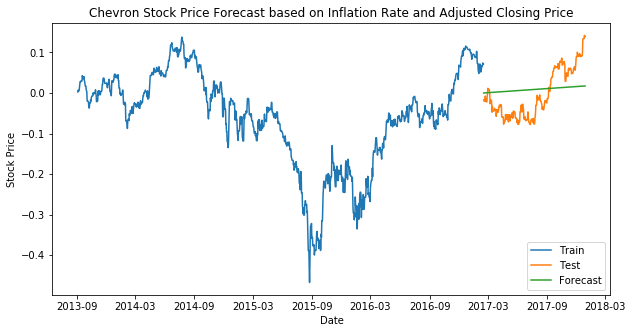

In [33]:
plt.figure(figsize= (10,5))
plt.plot(y_train_cumsum, label='Train')
plt.plot(y_test_cumsum, label='Test')
plt.plot(y_test.index, forecast_cumsum, label='Forecast')
plt.legend(loc='lower right')
plt.title('Chevron Stock Price Forecast based on Inflation Rate and Adjusted Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()